# Importing Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pickle
from wordcloud import WordCloud
sns.set()
pd.options.mode.chained_assignment = None
from prettytable import PrettyTable

# Loading Files

In [33]:
combined_df = pd.read_pickle('combined.pkl') # Main file on which we will work 
backup_df = pd.read_pickle('backup.pkl') # backup file without any alterations

all_dataframes = [] # Contains individual data frames for all countries in case we need to work with any of them individually
with open('all_dataframes.pkl', 'rb') as f:
    all_dataframes = pickle.load(f)

In [34]:
combined_df.head(3)

,title,channel_title,category,category_id,publish_time,publish_date,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,
ooyjaVdt-jA,Official Call of Duty®: Black Ops 4 — Multipla...,Call of Duty,Gaming,20,17:09:38,2018-05-17,"call of duty|""cod""|""activision""|""Black Ops 4""",10306119,357079,212976,144795,https://i.ytimg.com/vi/ooyjaVdt-jA/default.jpg,False,False,False,Call of Duty: Black Ops 4 Multiplayer raises t...,US,2018-06-14
NXwn1iUbbJU,Série ADJA - Episode 28,Marodi TV Sénégal,Entertainment,24,20:13:30,2018-06-13,"senegal|""video""|""divertissement""|""humour""|""you...",213980,3940,188,801,https://i.ytimg.com/vi/NXwn1iUbbJU/default.jpg,False,False,False,Retrouvez - nous sur http://www.marodi.tv ou t...,FR,2018-06-14
AN2KspjYRLc,UN YOUTUBER DANS L'EMISSION LA PLUS GÊNANTE DE...,Chelxie,Comedy,23,15:07:36,2018-06-12,"youtuber|""skyyart""|""les 12 coeurs""|""emission g...",176036,3673,1625,456,https://i.ytimg.com/vi/AN2KspjYRLc/default.jpg,False,False,False,un youtuber dans une emission génante france l...,FR,2018-06-14


# Sentiment Analysis

In this portion we will perform Sentiment Analysis. It is basically opinion mining to analyze opinions, sentiments, attitudes, and emotions of users which they express on social media. This comes under machine learning portion. There are many mechanisms to perform these kinds of analysis such as voting, rating, analysis of user comments etc.

##  Sentiment analysis using 'Tags' on 'Categories' of videos

Removing stopwords first. Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [35]:
english = stopwords.words('english') # For US, CA, and GB videos

counter = 0
for words in english:
    print(words)
    counter = counter + 1
    if counter > 10:
        break

# List of some of the stop words from english language. We can do the same for others as well e.g french, german.

i
me
my
myself
we
our
ours
ourselves
you
you're
you've


Storing stop words from other languages as well since our videos are from different regions

In [36]:
german = stopwords.words('german') # DE videos
french = stopwords.words('french') # FR videos
english.extend(german) # adding stopwords from german to english list
english.extend(french) # adding stopwords from french to english list

stopwords_list = [] # one huge combined list of stop words from different languages

for words in english:
    stopwords_list.append(words)

In [37]:
categories = combined_df['category'].unique() # unique video categories
categories

array(['Gaming', 'Entertainment', 'Comedy', 'Sports', 'Music',
       'Howto & Style', 'Film & Animation', 'People & Blogs', 'Education',
       'News & Politics', 'Pets & Animals', nan, 'Shows',
       'Travel & Events', 'Autos & Vehicles', 'Science & Technology',
       'Movies', 'Trailers'], dtype=object)

Function to extract tags from individual video categories

In [38]:
def extract_tags(category):
    temp = combined_df[combined_df['category'] == category]
    tags = []
    for t in temp['tags']:
        tags.append(t)
        
    return tags

Function for removing "|" from tags attribute. It also removes all the stop words as they are of no use. Numerics are removed aswell.

In [39]:
def clean_tags(tags):
    output = []
    for i in range(len(tags)):
        tags[i] = tags[i].lower()
        tags[i] = re.sub('[^A-Za-z]+', ' ', tags[i]) # to remove punctuation if any 
        tags[i] = tags[i].strip()
        tags[i] = word_tokenize(tags[i]) # it just splits words into individual words
        tags[i] = [w for w in tags[i] if not w in stopwords_list] # removing stopwords
        tags[i] = [word for word in tags[i] if len(word) > 2]  # removing any word whose length is 1 or 2
        tags[i] = [word for word in tags[i] if not word.isdigit()] # removing numerics
        for w in tags[i]:
            output.append(w)
    return output

Extracting all tags from all video categories

In [40]:
all = [] # contains final cleaned tags from every individual category
for c in categories:
    tags = extract_tags(c)
    cleaned = clean_tags(tags)
    all.append(cleaned)

Function to get polarity of a certain video category based on the tags for that category

In [41]:
def get_polarities(tags):
    max = 2000 # 2000 words to be taken from each category tags
    frequency = nltk.FreqDist(tags)
    temp = pd.DataFrame(frequency.most_common(max),
                    columns=['Word', 'Frequency'])
    compound = .0
    polarities = []
    for word in temp['Word'].head(max):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    return compound

Calculating polarities now

In [42]:
# This will take some time to run

polarities = [] # list of polarities from tags of individual categories
for a in all:
    polarity = get_polarities(a)
    polarities.append(polarity)

In [43]:
j = 0
t = PrettyTable(['Category', 'Polarity'])
for i in polarities:
    t.add_row([categories[j], i])
    j = j + 1
    
print(t)

+----------------------+---------------------+
|       Category       |       Polarity      |
+----------------------+---------------------+
|        Gaming        |  6.791599999999998  |
|    Entertainment     |  11.113000000000005 |
|        Comedy        |  12.597799999999996 |
|        Sports        |  10.717299999999998 |
|        Music         |  17.145300000000002 |
|    Howto & Style     |  23.949800000000003 |
|   Film & Animation   |  8.137999999999998  |
|    People & Blogs    |  18.054200000000005 |
|      Education       |  2.333100000000001  |
|   News & Politics    | -3.7098000000000004 |
|    Pets & Animals    |  13.465099999999996 |
|         nan          |         0.0         |
|        Shows         |  1.4337000000000004 |
|   Travel & Events    |  14.145299999999997 |
|   Autos & Vehicles   |       -3.0976       |
| Science & Technology |  6.686999999999999  |
|        Movies        |         1.85        |
|       Trailers       |         0.0         |
+------------

In [44]:
categories = pd.DataFrame(categories)
polarities = pd.DataFrame(polarities)

In [45]:
sentiments = pd.concat([categories, polarities], axis=1)

Plotting

Text(0.5, 1.0, 'Sentiment Analysis')

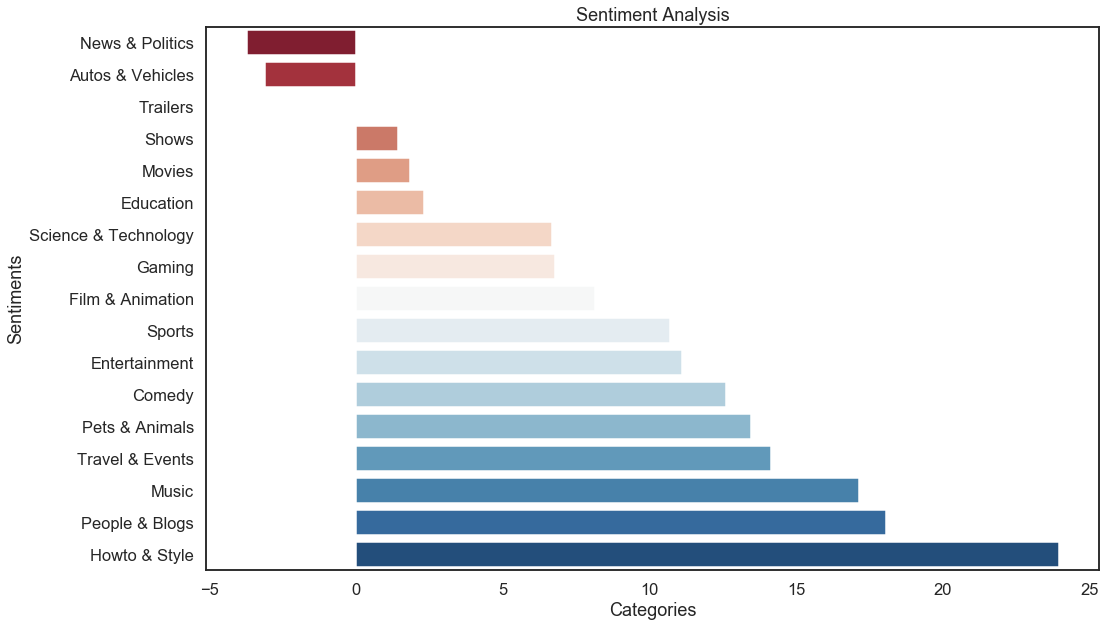

In [46]:
sentiments.columns = ['category', 'polarity']
sentiments = sentiments.sort_values('polarity').reset_index()

fig = plt.figure(figsize=(16, 10))
sns.set(style="white", context="talk")
ax = sns.barplot(x=sentiments['polarity'], y=sentiments['category'], data=sentiments,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("Sentiments")
plt.title("Sentiment Analysis")

All the 2000 most frequent tags from each category were examined. Negative values indicate that most of the tags have negative sentiments and positive shows positive sentiments. News & Politics videos have most negative sentiment with its tags whereas Howto and Style has the most positive sentiments.

##  Tags in most negative and most positive sentiments

For most negative...

(-0.5, 399.5, 199.5, -0.5)

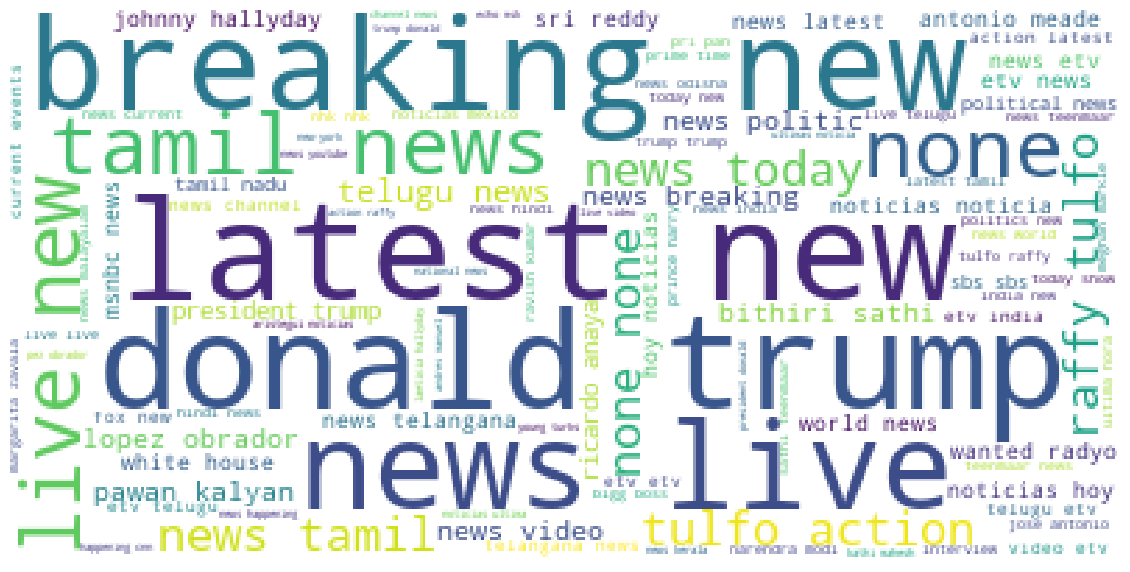

In [47]:
neg = all[9] 

plt.figure(figsize = (20,15))
cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
cloud.generate(' '.join(neg))
plt.imshow(cloud)
plt.axis('off')

And for most positive...

(-0.5, 399.5, 199.5, -0.5)

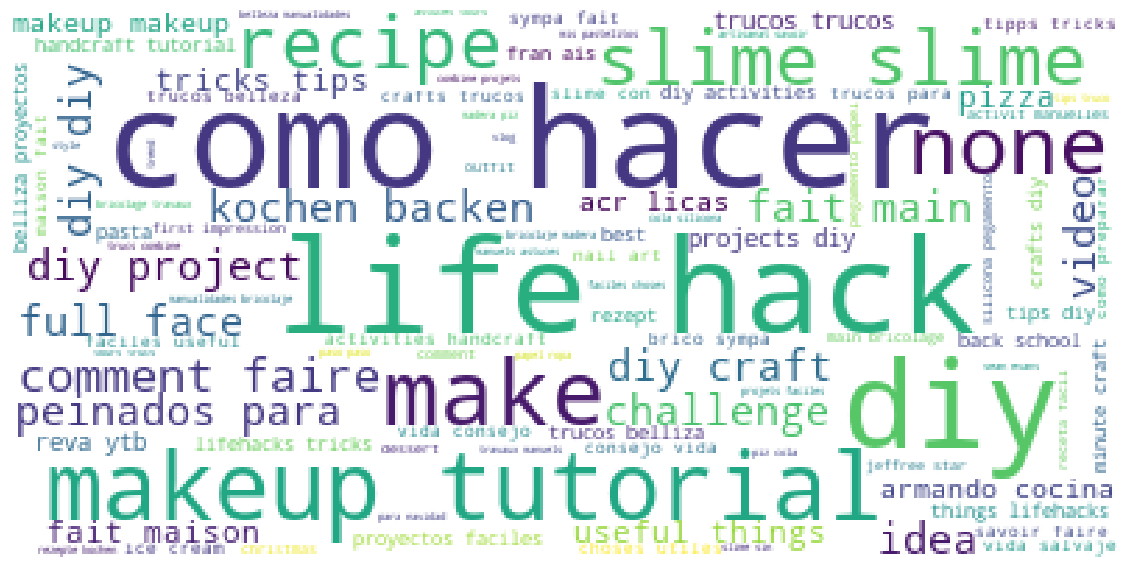

In [48]:
pos = all[5] 

plt.figure(figsize = (20,15))
cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
cloud.generate(' '.join(pos))
plt.imshow(cloud)
plt.axis('off')

# Linear Regression

In this portion we will make use of linear regression to predict the number of views based on other factors such as likes.

In [55]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import random
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [56]:
cwd = os.getcwd()
random.seed( 30 )

#Reading the dataset CAvideos.csv
df = all_dataframes[0]

y = df.views

In [57]:
# create training and testing vars by splitting data at 80/20 split
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [58]:
# setting likes as the independent variable"x_axis" in train data and test data to see the its effect on views 
predictors = ["likes","dislikes"]
x_train = x_train[predictors]
x_test = x_test[predictors]

In [59]:
#Training the model using our training data and predicting test views using x_test which are likes in test data
lm = linear_model.LinearRegression()
model = lm.fit(x_train, y_train)
predictions = lm.predict(x_test)

In [60]:
#To retrieve the intercept:
print(lm.intercept_)
#For retrieving the slope:
print('regressor coffecient:',lm.coef_)

313316.4725452829
regressor coffecient: [19.35655124 38.32662797]


Plotting the barchart to show the differeneces between the acutal and predicted values


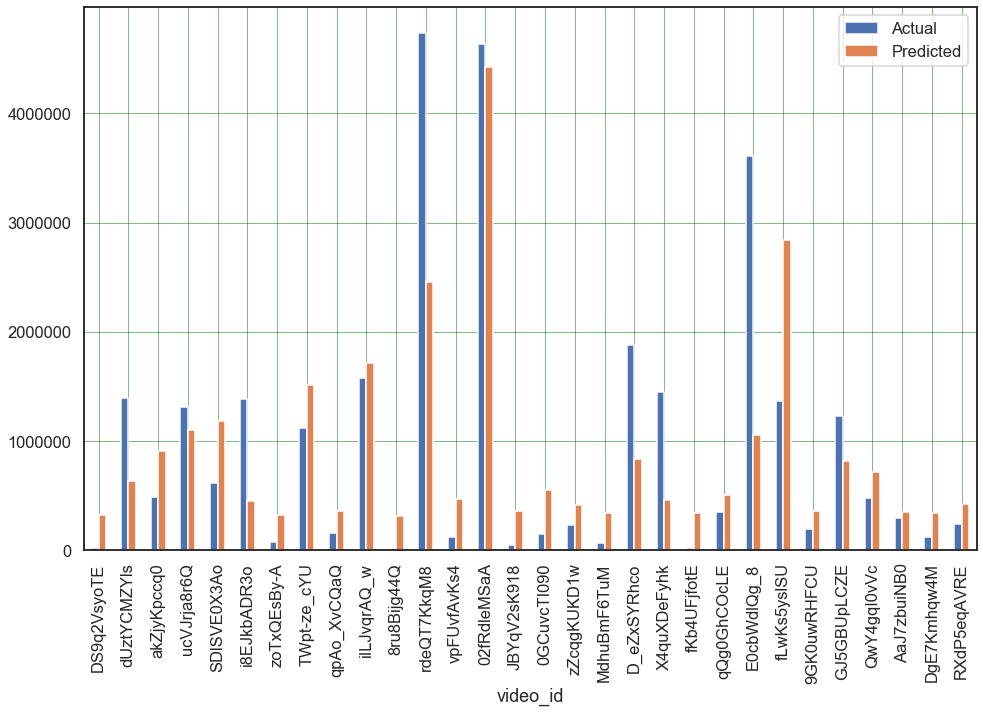

In [61]:
#Plotting the barchart to show the differeneces between the acutal and predicted values
print('Plotting the barchart to show the differeneces between the acutal and predicted values')
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df1 = df.head(30)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Plotting scatter plot to show the relationship between views and likes and plot the computed regression line w.r.t predicted data over the actual data points to evaluate the results


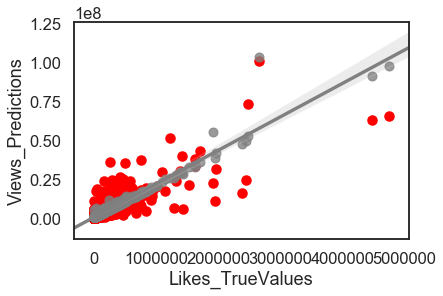


Plotting scatter plot to show the relationship between views and dislikes and plot the computed regression line w.r.t predicted data over the actual data points to evaluate the results


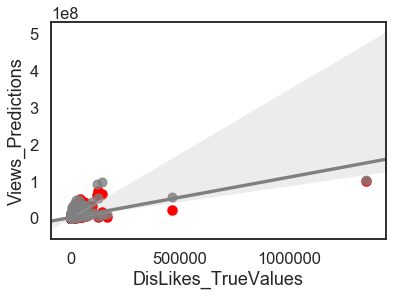

In [62]:
#Plotting scatter plot to show the relationship between views and likes

print('Plotting scatter plot to show the relationship between views and likes and plot the computed regression line w.r.t predicted data over the actual data points to evaluate the results')
plt.scatter(x_test.likes, y_test,  color='red')
sns.regplot(x=x_test.likes,y=predictions,color='gray')
plt.xlabel('Likes_TrueValues')
plt.ylabel('Views_Predictions')
plt.show()
print()

print('Plotting scatter plot to show the relationship between views and dislikes and plot the computed regression line w.r.t predicted data over the actual data points to evaluate the results')
plt.scatter(x_test.dislikes, y_test,  color='red')
sns.regplot(x=x_test.dislikes,y=predictions,color='gray')
plt.xlabel('DisLikes_TrueValues')
plt.ylabel('Views_Predictions')
plt.show()
print()


While most of the data points are clustered towards the lower left corner of the plot, there are a few points which lie far away from the main cluster of the data. These points are known as outliers, and depending on their location may have a major impact on the regression line

In [63]:
# print(“Score:”) to show our model is reasonable or not
print('Score')
print (model.score(x_test, y_test))

Score
0.7038598812055201


# Observation

We took likes and dislikes as our features (independent variable) and views as dependent variables to check if views(video being trending) depends upon the number of likes and dislikes. After training model on the train data(which was 80% of the original data), we predicted the number of views with the help of our trained model and number of likes and dislikes in test data. The coeffecient of model came out to be approx 18 for likes and approx 43 for dislikes and  which means that for every 21 views there is a like on a video and for every 43 views there is a dislike on a video. So greater the number of likes and dislikes means greater number of views hence it can be deduced that the video is trending. The model score came out to be approx 0.75 which means that this deduction is reasonably good. Bar chart shows the differnce (between predicted and actual views values for the first 30 videos) which is minimal. Scatter plot depicts that the model worked correctly and both views and likes are linearly related and views and dislikes are also linearly related. So after analyzing all of the above results, we can say that the videos which have more likes and dislikes are mostly trending.